# setup

loading csvs

In [ ]:
import pandas as pd

stories_gh_ai = []
stories_gh_nonai = []
stories_gh = []

story_gh_ai_csv_path = './hn-stories-gh-ai.csv'
for chunk in  pd.read_csv(story_gh_ai_csv_path, sep=',', chunksize=2000):
    stories_gh_ai.append(chunk)

story_gh_nonai_csv_path = './hn-stories-gh-nonai.csv'
for chunk in  pd.read_csv(story_gh_nonai_csv_path, sep=',', chunksize=2000):
    stories_gh_nonai.append(chunk)

story_gh_csv_path = './hn-stories-gh.csv'
for chunk in  pd.read_csv(story_gh_csv_path, sep=',', chunksize=2000):
    stories_gh.append(chunk)

# Concatenate all chunks into a single DataFrame
stories_gh_ai_df = pd.concat(stories_gh_ai)
stories_gh_nonai_df = pd.concat(stories_gh_nonai)
stories_gh_df = pd.concat(stories_gh)

In [25]:

# Count the number of rows
print(f"Total number of stories in {story_gh_ai_csv_path}: {len(stories_gh_ai_df)}")
print(f"Total number of stories in {story_gh_nonai_csv_path}: {len(stories_gh_nonai_df)}")
print(f"Total number of stories in {story_gh_csv_path}: {len(stories_gh_df)}")

Total number of stories in ./hn-stories-gh-ai.csv: 2195
Total number of stories in ./hn-stories-gh-nonai.csv: 22455
Total number of stories in ./hn-stories-gh.csv: 24650


# graphing

## graphing total hackernews stories over time

In [11]:
import matplotlib.pyplot as plt

def plot_hist_stories(df, name: str):
    # Convert the 'timestamp' column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    plt.figure(figsize=(15, 7))
    plt.hist(df['timestamp'], bins=50, edgecolor='black')
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Stories')
    plt.title(name)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.grid(True, alpha=0.8)
    plt.show()

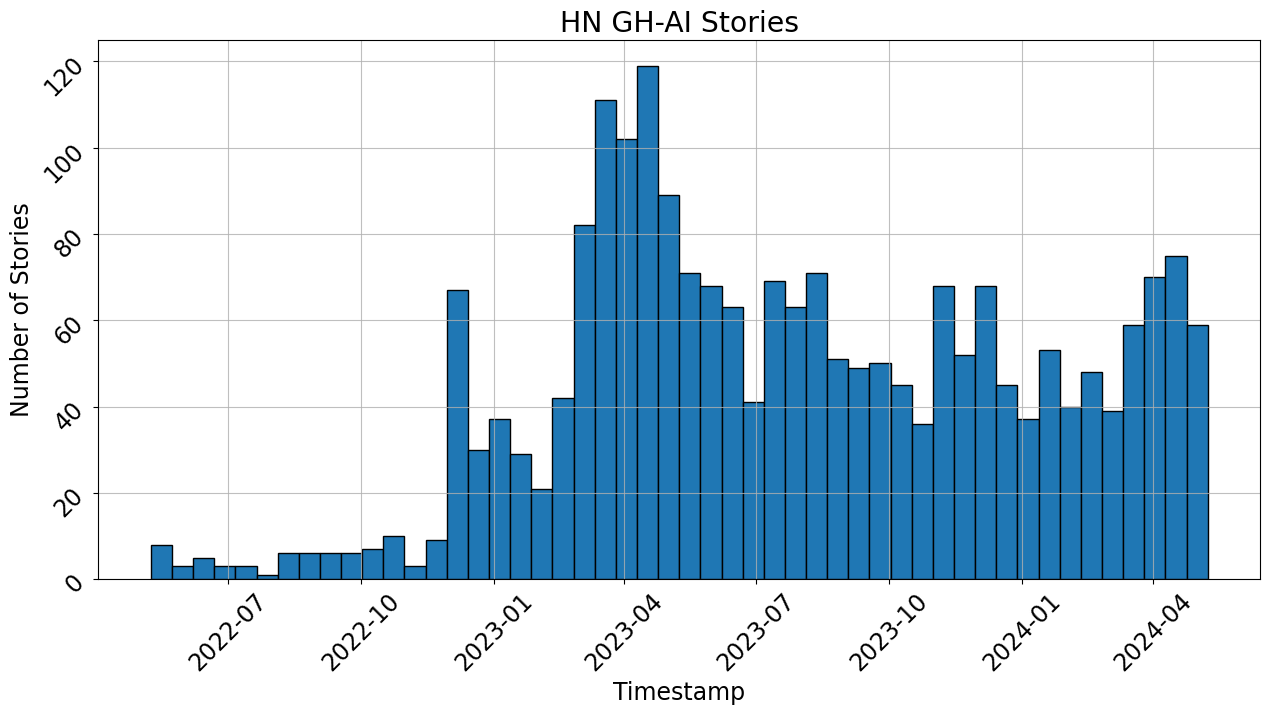

In [14]:
plot_hist_stories(stories_gh_ai_df, 'HN GH-AI Stories')

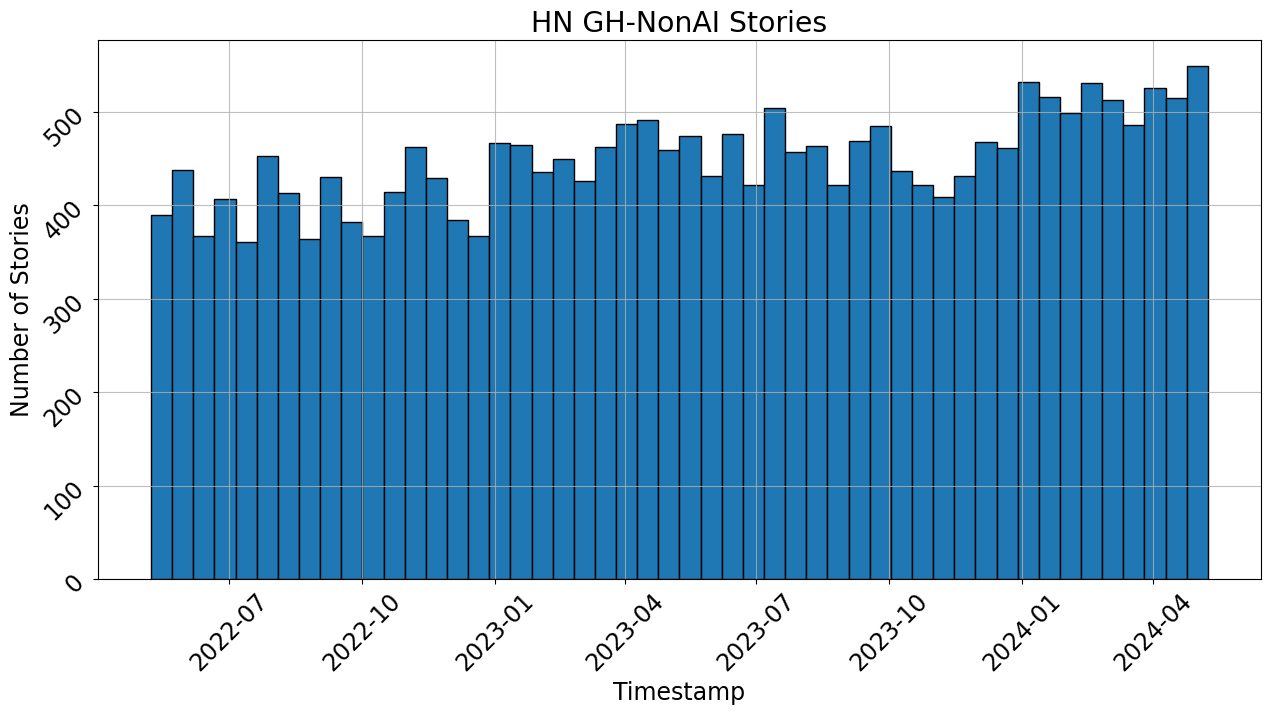

In [15]:
plot_hist_stories(stories_gh_nonai_df, 'HN GH-NonAI Stories')

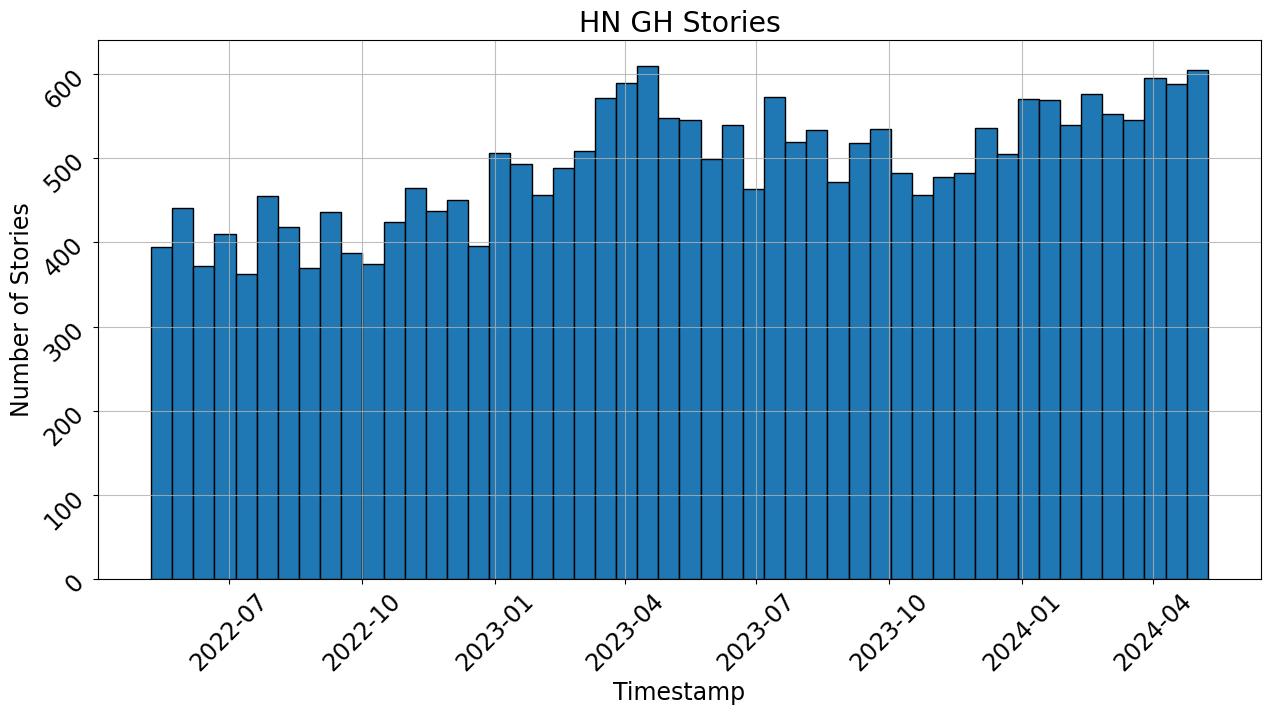

In [26]:
plot_hist_stories(stories_gh_df, 'HN GH Stories')

## graphing by keywords

In [16]:
# open txt file containing keywords
keywords_txt = 'rq1_ai_keywords.txt'
with open(keywords_txt, 'r') as f:
    keywords = f.read().splitlines()

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 17})

def plot_combined_keyword_trends(title, all_stories_df, keywords):
    """
    Plot multiple keywords' trends over time in a single line graph.

    Args:
    title (str): The graph's title
    all_stories_df (DataFrame): The DataFrame containing the HN stories
    keywords (list): List of keywords to plot
    """
    # Make a copy to avoid modifying the original DataFrame
    df = all_stories_df.copy()

    # Ensure we have a date column for binning
    if 'timestamp' in df.columns:
        # Convert to datetime first, then to Unix timestamp (seconds since epoch)
        df['date'] = pd.to_datetime(df['timestamp']).astype('int64') // 10**9
    elif 'time' in df.columns:
        # The time column appears to already be a Unix timestamp
        df['date'] = df['time']
    else:
        raise ValueError("No timestamp column found in the dataframe")

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-09').timestamp()

    # Set bin size to 14 days
    bin_size_days = 14
    total_days = (end_date - start_date) / (24 * 60 * 60)
    bins = int(total_days / bin_size_days)

    # Create the figure with larger size for better readability
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create bin edges
    bin_edges = np.linspace(start_date, end_date, bins + 1)

    # Plot line for each keyword
    for keyword in keywords:
        # Filter the dataframe based on the keyword (check if title is not None first)
        keyword_df = df[df['title'].notna() & df['title'].str.contains(fr'\b{keyword}\b', case=False, regex=True)]

        # Create histogram data
        hist, _ = np.histogram(keyword_df['date'], bins=bin_edges)

        # Calculate the center of each bin for x-axis
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot the line
        ax.plot(bin_centers, hist, label=keyword, marker='o', markersize=3, linewidth=2)

    # Format x-axis ticks as dates
    def timestamp_to_date(timestamp):
        return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

    num_ticks = 8  # Increased number of ticks for better temporal resolution
    tick_locations = np.linspace(start_date, end_date, num_ticks)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels([timestamp_to_date(t) for t in tick_locations], rotation=45)

    # Add ChatGPT release line
    chatgpt_release = pd.Timestamp('2022-11-30').timestamp()
    ax.axvline(x=chatgpt_release, color='red', linestyle='--')

    # Customize the plot
    # ax.set_title(f'{title}\nBin Size: {bin_size_days} days', pad=20)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Discussions')

    # Create a separate legend for ChatGPT release line
    chatgpt_legend = ax.legend([plt.Line2D([0], [0], color='red', linestyle='--')],
                               ['ChatGPT Release'],
                               loc='upper left', fontsize=14, frameon=True)
    ax.add_artist(chatgpt_legend)

    # Optimize legend placement and formatting for keywords
    ax.legend(bbox_to_anchor=(-0.04, -0.6), loc='lower left', borderaxespad=0.,
              title='Keywords', title_fontsize=18, fontsize=18, ncol=4)

    # Add grid
    ax.grid(visible=True, alpha=0.7)

    # Save and show the plot
    plt.savefig('hn_trends_keywords_combined.png', bbox_inches='tight', dpi=300)
    plt.show()

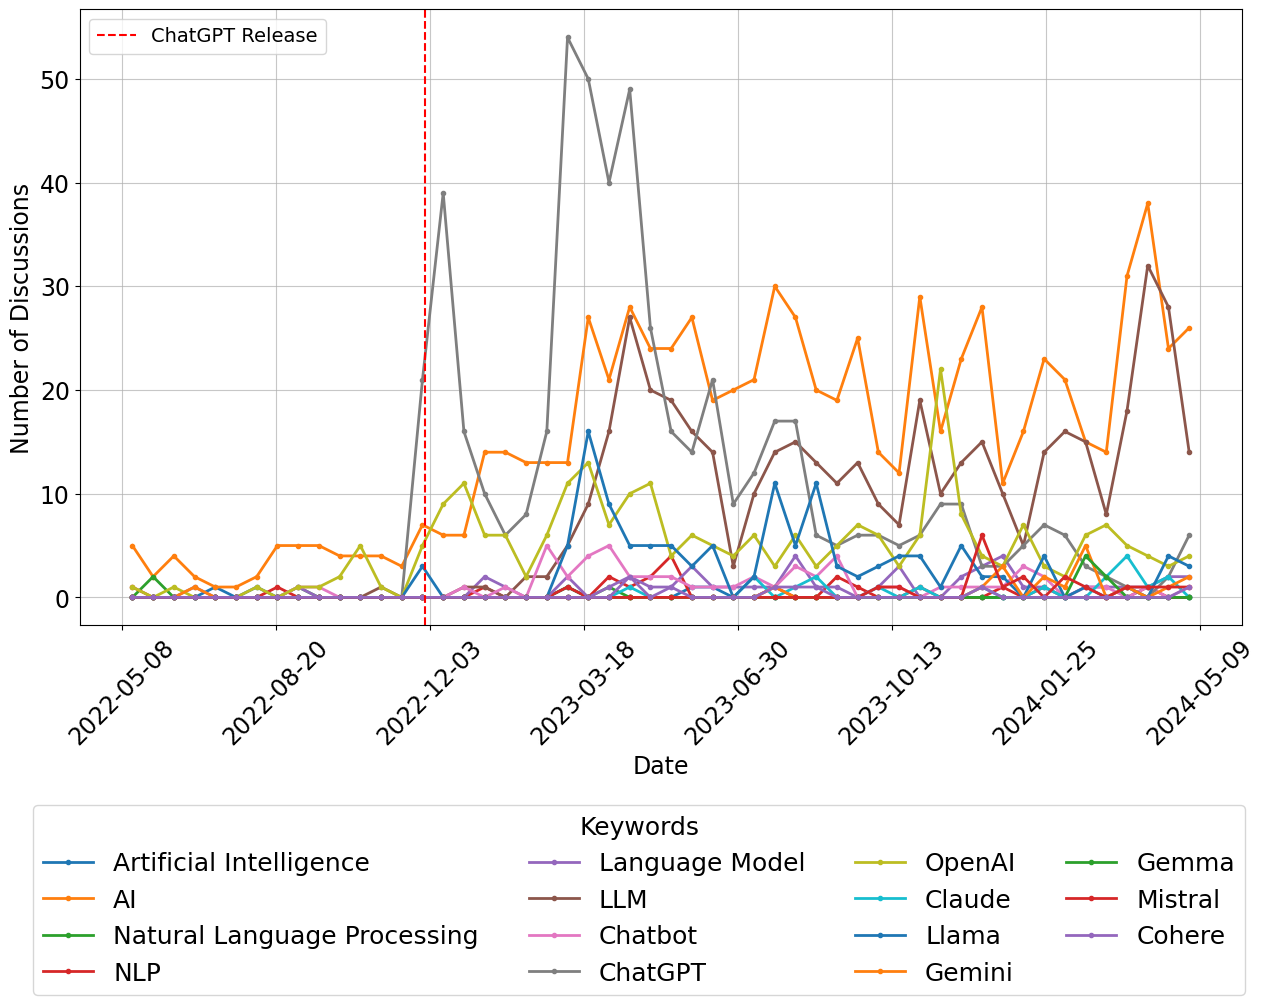

In [29]:
plot_combined_keyword_trends("Hacker News Keyword Trends", stories_gh_ai_df, keywords)